This is a notebook to create a model that will answer the problem of assiging a genre to a song based on Spotify
metadata.  For this problem I have chosen to use a multiclass classification neural network with the backend being
writen in pytorch. This model will be able to beat our baseline score by a magnitude of 10.

Imports

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Read in clean data

In [151]:
data = pd.read_csv('../data/clean_data.csv')

data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,mode_1
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,2Vc6NJ9PW9gD9q343XFRKx,...,0,0,0,0,0,0,0,1,0,1
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,7pgJBLVz5VmnL7uGHmRj6p,...,0,0,1,0,0,0,0,1,0,1
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,0vSWgAlfpye0WCGeNmuNhy,...,0,0,0,0,0,0,0,1,0,1
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,0VSXnJqQkwuH2ei1nOQ1nu,...,0,0,0,0,0,0,1,0,0,1
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,4jCeguq9rMTlbMmPHuO7S3,...,0,0,0,0,0,0,0,1,0,1


In [152]:
data.info()

classes = data['genre'].unique()
num_classes = len(classes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   danceability          42305 non-null  float64
 1   energy                42305 non-null  float64
 2   loudness              42305 non-null  float64
 3   speechiness           42305 non-null  float64
 4   acousticness          42305 non-null  float64
 5   instrumentalness      42305 non-null  float64
 6   liveness              42305 non-null  float64
 7   valence               42305 non-null  float64
 8   tempo                 42305 non-null  float64
 9   id                    42305 non-null  object 
 10  duration_ms           42305 non-null  int64  
 11  genre                 42305 non-null  int64  
 12  song_name             42299 non-null  object 
 13  song_name_char_count  42305 non-null  int64  
 14  song_name_word_count  42305 non-null  int64  
 15  key_1              

In [153]:
X = data.drop(columns=['id','genre', 'song_name'])
y = np.array(data['genre'])

type(y)
y

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int64)

Split data into training and testing datasets

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify= y)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)



y_train


array([ 1, 11, 13, ..., 14,  9,  9], dtype=int64)

In [155]:
X_train_t = torch.tensor(X_train_sc).float()
y_train_t = torch.tensor(y_train).long()

X_test_t = torch.tensor(X_test_sc).float()
y_test_t = torch.tensor(y_test).long()
y_train_t
nodes = X_train_t.shape[1]
nodes

27

In [156]:
class MultiClassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(nodes, 32)
        self.h2 = nn.Linear(32, 32)
        self.h3 = nn.Linear(32, 32)
        self.h4 = nn.Linear(32, 64)
        self.h5 = nn.Linear(64, 64)
        self.h6 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 15)

    def forward(self, X):
        X = F.relu(self.h1(X))
        X = F.relu(self.h2(X))
        X = F.relu(self.h3(X))
        X = F.relu(self.h4(X))
        X = F.relu(self.h5(X))
        X = F.relu(self.h6(X))
        return self.out(X)


model = MultiClassModel()

loss_fn = nn.CrossEntropyLoss()

Create `torch.optim.Adam()` optimizer.

In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [158]:
train_loss = []
testing_loss = []
train_accuracy = []
test_accuracy = []
batch_size = 256
training_size = X.shape[0]
count = 0
epochs = 85
for epoch in range(epochs):
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = loss_fn(test_pred,y_test_t)
        testing_loss.append(test_loss.item())
        train_pred = model(X_train_t)
        loss = loss_fn(train_pred, y_train_t)
        train_loss.append(loss.item())
        train_accuracy.append((train_pred.argmax(axis=1) == y_train_t).float().mean())
        test_accuracy.append((test_pred.argmax(axis=1) == y_test_t).float().mean())
    for batch_idx in range(0, training_size, batch_size):
        # zero out the optimizer's gradients
        optimizer.zero_grad()

        # Create X_batch and y_batch
        X_batch = X_train_t[batch_idx:batch_idx + batch_size]
        y_batch = y_train_t[batch_idx:batch_idx + batch_size]

        # get predictions and loss
        pred = model(X_batch)

        loss = loss_fn(pred, y_batch)
        # back propagate
        loss.backward()

        # step
        optimizer.step()
    if count % (epochs//10) == 0:
        print(f'Model is {(count/epochs) * 100}% done.')

How did the model do?

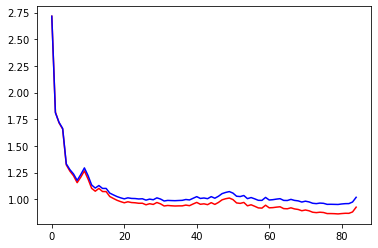

In [159]:
plt.plot(train_loss, color='red')
plt.plot(testing_loss, color= 'blue')


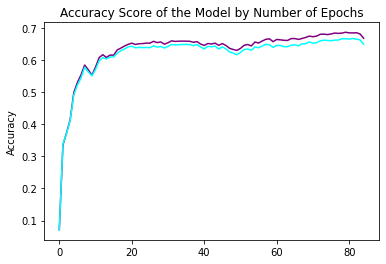

In [160]:
plt.plot(train_accuracy, color= 'purple')
plt.plot(test_accuracy, color= 'cyan')
plt.title('Accuracy Score of the Model by Number of Epochs')
plt.ylabel('Accuracy')
plt.savefig('../imgs/accuracy_model_before_reg.png', dpi= 400)


Implement Dropout Regularization.

In this section I will build a new Neural Network with dropout regularization.

In [176]:
model_drop = torch.nn.Sequential()

model_drop.add_module("dropout1", torch.nn.Dropout(p=0.2))
#first module with the number of nodes as the number of features, 27
#also this module will output 500 different nodes.
model_drop.add_module("dense1", torch.nn.Linear(nodes,1024))
model_drop.add_module("relu1", torch.nn.ReLU())
model_drop.add_module("dropout2", torch.nn.Dropout(p=0.3))

model_drop.add_module("dense2", torch.nn.Linear(1024,512))
model_drop.add_module("relu2", torch.nn.ReLU())
model_drop.add_module("dropout3", torch.nn.Dropout(p=0.3))


model_drop.add_module("dense3", torch.nn.Linear(512,256))
model_drop.add_module("relu3", torch.nn.ReLU())
model_drop.add_module("dropout4", torch.nn.Dropout(p=0.4))

model_drop.add_module("dense4", torch.nn.Linear(256,128))
model_drop.add_module("relu4", torch.nn.ReLU())
model_drop.add_module("dropout5", torch.nn.Dropout(p=0.3))

# model_drop.add_module("dense5", torch.nn.Linear(128,64))
# model_drop.add_module("relu5", torch.nn.ReLU())
# model_drop.add_module("dropout6", torch.nn.Dropout(p=0.3))
#
# model_drop.add_module("dense6", torch.nn.Linear(64,32))
# model_drop.add_module("relu6", torch.nn.ReLU())
# model_drop.add_module("dropout7", torch.nn.Dropout(p=0.5))

model_drop.add_module("dense7", torch.nn.Linear(128,num_classes))




drop_loss = torch.nn.CrossEntropyLoss()

In [177]:
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=.001)

In [178]:
train_loss_d = []
testing_loss_d = []
train_accuracy_d = []
test_accuracy_d = []
batch_size = 4096
training_size = X.shape[0]
count = 0
epochs = 1000
for epoch in range(epochs):
    with torch.no_grad():
        test_pred = model_drop(X_test_t)
        test_loss = drop_loss(test_pred,y_test_t)
        testing_loss_d.append(test_loss.item())
        train_pred = model_drop(X_train_t)
        loss = drop_loss(train_pred, y_train_t)
        train_loss_d.append(loss.item())
        train_accuracy_d.append((train_pred.argmax(axis=1) == y_train_t).float().mean())
        test_accuracy_d.append((test_pred.argmax(axis=1) == y_test_t).float().mean())
    for batch_idx in range(0, training_size, batch_size):
        # zero out the optimizer's gradients
        optimizer_drop.zero_grad()

        # Create X_batch and y_batch
        X_batch = X_train_t[batch_idx:batch_idx + batch_size]
        y_batch = y_train_t[batch_idx:batch_idx + batch_size]

        # get predictions and loss
        pred = model_drop(X_batch)

        loss = drop_loss(pred, y_batch)
        # back propagate
        loss.backward()

        # step
        optimizer_drop.step()
    count += 1
    if count % (epochs//20) == 0:
        print(f'Model is {(count/epochs) * 100}% done.')

Model is 5.0% done.
Model is 10.0% done.
Model is 15.0% done.
Model is 20.0% done.
Model is 25.0% done.
Model is 30.0% done.
Model is 35.0% done.
Model is 40.0% done.
Model is 45.0% done.
Model is 50.0% done.
Model is 55.00000000000001% done.
Model is 60.0% done.
Model is 65.0% done.
Model is 70.0% done.
Model is 75.0% done.
Model is 80.0% done.
Model is 85.0% done.
Model is 90.0% done.
Model is 95.0% done.
Model is 100.0% done.


How did the model do?

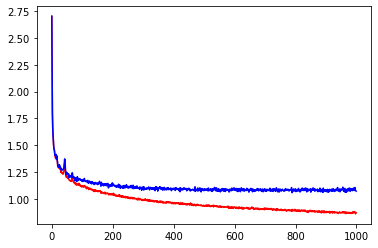

In [179]:
plt.plot(train_loss_d, color='red')
plt.plot(testing_loss_d, color= 'blue')


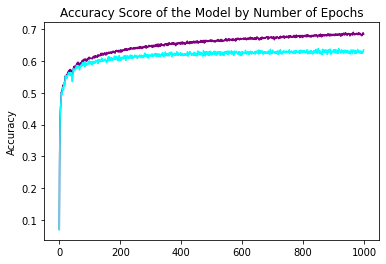

In [180]:
plt.plot(train_accuracy_d, color= 'purple')
plt.plot(test_accuracy_d, color= 'cyan')
plt.title('Accuracy Score of the Model by Number of Epochs')
plt.ylabel('Accuracy')
plt.savefig('../imgs/accuracy_model_after_reg.png', dpi= 400)

In [166]:
# with torch.no_grad():
#     pred = model(X_test_t)
# (pred.argmax(axis=1) == y_test_t).float().mean()


